# Energy balances June 2021 edition

Load, clean and transform the provided `nrg_bal` [TSV file](https://ec.europa.eu/eurostat/web/energy/data/database) (fix mixed tabs and commas as separator, fill missing data, change shape).

Fuel and variable codes are described in the [manual](https://ec.europa.eu/eurostat/documents/38154/4956218/ENERGY-BALANCE-GUIDE-DRAFT-31JANUARY2019.pdf/cf121393-919f-4b84-9059-cdf0f69ec045) or in the [Standard international energy product classification (SIEC)](http://dd.eionet.europa.eu/vocabulary/eurostat/siec/) vocabulary and [Energy balance](http://dd.eionet.europa.eu/vocabulary/eurostat/nrg_bal/) vocabulary.

In [1]:
import pandas as pd

In [2]:
# https://ec.europa.eu/eurostat/web/energy/data/database
url = "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_bal_c.tsv.gz"

In [3]:
# The original tsv has mixed separators, both \t and ,
tsv = pd.read_csv(url, sep="\t", na_values=[": ", ": z"])

In [4]:
tsv.head()

,"nrg_bal,siec,unit,geo\time",2019,2018,2017,2016,2015,2014,2013,2012,2011,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,"AFC,BIOE,GWH,AL",3211.056,3129.617,2804.720,3049.733,2728.383,2547.175,2343.333,2401.667,2419.167,...,3046.944,3192.500,3344.722,3504.167,3671.389,3846.389,4029.722,4221.944,4221.944,4221.944
1,"AFC,BIOE,GWH,AT",55053.493,55691.874,58228.039,57876.168,57507.590,55017.991,57442.227,56631.469,54608.670,...,31906.583,27778.728,28863.769,29117.247,27703.651,25186.310,27367.890,27110.141,27905.111,25744.633
2,"AFC,BIOE,GWH,BA",13990.576,13379.486,4843.579,5936.294,5937.175,4618.269,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"AFC,BIOE,GWH,BE",25893.302,27909.472,27095.565,27009.755,25268.877,24461.421,25717.198,24044.472,21905.617,...,5226.635,4792.250,4198.739,4464.628,4344.736,3076.269,3139.375,3958.904,4108.185,4034.103
4,"AFC,BIOE,GWH,BG",16781.094,16364.406,14661.761,14428.844,13753.572,12695.771,13328.990,12785.630,11240.794,...,4900.556,4759.722,2776.667,2724.166,2394.221,1865.723,1656.454,1818.057,1333.333,2005.833


In [5]:
# Split the comma separated columns
meta = pd.DataFrame(tsv["nrg_bal,siec,unit,geo\\time"].str.split(",").tolist(), columns=["variable", "siec", "unit", "country"])

In [6]:
# Trailing space in some column names representing years
years = tsv.filter(regex="[0-9]* +")
years.columns = [col.strip() for col in years.columns]

In [7]:
# Merge comma and tab separated parts of the dataset
df = meta.merge(years, left_index=True, right_index=True)

In [8]:
df.head()

,variable,siec,unit,country,2019,2018,2017,2016,2015,2014,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,AFC,BIOE,GWH,AL,3211.056,3129.617,2804.720,3049.733,2728.383,2547.175,...,3046.944,3192.500,3344.722,3504.167,3671.389,3846.389,4029.722,4221.944,4221.944,4221.944
1,AFC,BIOE,GWH,AT,55053.493,55691.874,58228.039,57876.168,57507.590,55017.991,...,31906.583,27778.728,28863.769,29117.247,27703.651,25186.310,27367.890,27110.141,27905.111,25744.633
2,AFC,BIOE,GWH,BA,13990.576,13379.486,4843.579,5936.294,5937.175,4618.269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFC,BIOE,GWH,BE,25893.302,27909.472,27095.565,27009.755,25268.877,24461.421,...,5226.635,4792.250,4198.739,4464.628,4344.736,3076.269,3139.375,3958.904,4108.185,4034.103
4,AFC,BIOE,GWH,BG,16781.094,16364.406,14661.761,14428.844,13753.572,12695.771,...,4900.556,4759.722,2776.667,2724.166,2394.221,1865.723,1656.454,1818.057,1333.333,2005.833


In [9]:
# Melt and pivot to have variables as columns and fuel, unit, country and year as multiindex
# Change year type from string to integer
melted = df.melt(id_vars=["variable", "siec", "unit", "country"], var_name="year")
melted = melted.astype({"year": "int64"})
melted.head()

,variable,siec,unit,country,year,value
0,AFC,BIOE,GWH,AL,2019,3211.056
1,AFC,BIOE,GWH,AT,2019,55053.493
2,AFC,BIOE,GWH,BA,2019,13990.576
3,AFC,BIOE,GWH,BE,2019,25893.302
4,AFC,BIOE,GWH,BG,2019,16781.094


In [10]:
melted_reindexed = melted.set_index(keys=["siec", "unit", "country", "year"])

In [11]:
# Pivot and remove unused level from columns axis and unset names
b = melted_reindexed.pivot(columns="variable")
b = b.droplevel(0, axis=1)
b.columns.name = None
b.index.name = None

In [12]:
b.head()

AFC   DL  EXP      FC_E  FC_IND_CON_E  \
siec unit country year                                               
BIOE GWH  AL      1990  4221.944  0.0  0.0  4221.944           0.0   
                  1991  4221.944  0.0  0.0  4221.944           0.0   
                  1992  4221.944  0.0  0.0  4221.944           0.0   
                  1993  4029.722  0.0  0.0  4029.722           0.0   
                  1994  3846.389  0.0  0.0  3846.389           0.0   

                        FC_IND_CPC_E  FC_IND_E  FC_IND_FBT_E  FC_IND_IS_E  \
siec unit country year                                                      
BIOE GWH  AL      1990           0.0       0.0           0.0          0.0   
                  1991           0.0       0.0           0.0          0.0   
                  1992           0.0       0.0           0.0          0.0   
                  1993           0.0       0.0           0.0          0.0   
                  1994           0.0       0.0           0.0          0.0   

                        FC_IND_MAC_E  ...  TO_LBB  TO_NSP  TO_PF  TO_RPI  \
siec unit country year                ...                                  
BIOE GWH  AL      1990           0.0  ...     0.0     0.0    0.0     0.0   
                  1991           0.0  ...     0.0     0.0    0.0     0.0   
                  1992           0.0  ...     0.0     0.0    0.0     0.0   
                  1993           0.0  ...     0.0     0.0    0.0     0.0   
                  1994           0.0  ...     0.0     0.0    0.0     0.0   

                        TO_RPI_BKFLOW  TO_RPI_IT  TO_RPI_PIR  TO_RPI_PPR  \
siec unit country year                                                     
BIOE GWH  AL      1990            0.0        0.0         0.0         0.0   
                  1991            0.0        0.0         0.0         0.0   
                  1992            0.0        0.0         0.0         0.0   
                  1993            0.0        0.0         0.0         0.0   
                  1994            0.0        0.0         0.0         0.0   

                        TO_RPI_PT  TO_RPI_RO  
siec unit country year                        
BIOE GWH  AL      1990        0.0        0.0  
                  1991        0.0        0.0  
                  1992        0.0        0.0  
                  1993        0.0        0.0  
                  1994        0.0        0.0  

[5 rows x 138 columns]

In [13]:
# Export to csv
b.reset_index().to_csv("nrg_bal.csv", index=False)

In [14]:
# Example usage
b.loc[pd.IndexSlice[:, "TJ", "CZ", :], ["PPRD", "EXP", "IMP", "GIC"]]

PPRD      EXP      IMP        GIC
siec  unit country year                                        
BIOE  TJ   CZ      1990  43578.000    0.000    0.000  43578.000
                   1991  43989.000    0.000    0.000  43989.000
                   1992  65044.800    0.000    0.000  65030.000
                   1993  63900.200   79.300   58.589  63894.289
                   1994  61068.400  115.353  165.794  61126.240
...                            ...      ...      ...        ...
W6220 TJ   CZ      2015   2228.000    0.000    0.000   2228.000
                   2016   2387.000    0.000    0.000   2387.000
                   2017   2568.955    0.000    0.000   2568.955
                   2018   2445.865    0.000    0.000   2445.865
                   2019   2550.320    0.000    0.000   2550.320

[2160 rows x 4 columns]

In [15]:
bio_cz_pprd = b.loc[pd.IndexSlice["BIOE", "TJ", "CZ", :], ["PPRD"]]

<AxesSubplot:title={'center':'Primary production of bioenergy in Czechia'}, xlabel='year', ylabel='Terajoules'>

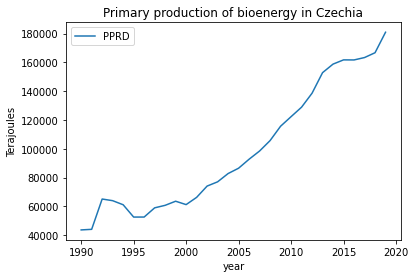

In [16]:
bio_cz_pprd.droplevel([0,1,2]).plot(
    title="Primary production of bioenergy in Czechia",
    ylabel="Terajoules"
    )

In [17]:
bio_cz_exp = b.loc[pd.IndexSlice["BIOE", "TJ", "CZ", :], ["EXP"]]

<AxesSubplot:title={'center':'Exports of bioenergy in Czechia'}, xlabel='year', ylabel='Terajoules'>

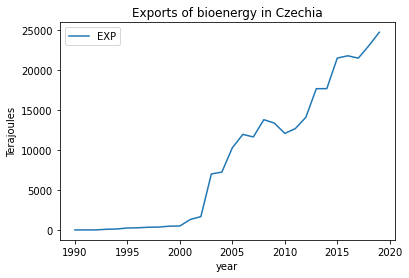

In [18]:
bio_cz_exp.droplevel([0,1,2]).plot(
    title="Exports of bioenergy in Czechia",
    ylabel="Terajoules"
    )

In [19]:
bio_de_pprd = b.loc[pd.IndexSlice["BIOE", "TJ", "DE", :], ["PPRD"]]

<AxesSubplot:title={'center':'Primary production of bioenergy in Germany'}, xlabel='year', ylabel='Terajoules'>

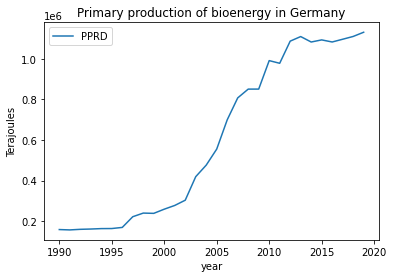

In [20]:
bio_de_pprd.droplevel([0,1,2]).plot(
    title="Primary production of bioenergy in Germany",
    ylabel="Terajoules"
    )

In [21]:
b.loc[pd.IndexSlice[:, :, ["CZ", "DE", "FR", "PL", "SE", "EU27"], :]].reset_index().to_csv("nrg_bal_selected.csv", index=False)